In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
sys.path.append('../')

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from clearml import Task
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, ModelSummary
from torch import nn
from torch.utils.data import DataLoader
from transformers import BertConfig, BertModel

from src.datasets import MaskedLMDataset, MaskedLMPredictionDataset, PaddingCollateFn
from src.models import BERT4Rec
from src.modules import SeqRec

from src.metrics import Evaluator
from src.postprocess import preds2recs
from src.preprocess import add_time_idx, filter_items, filter_users
from src.utils import extract_validation_history

from sklearn.model_selection import train_test_split

## Load data

In [3]:
data_path='../data/ml-1m.csv'
# data_path='../data/ml-20m.csv'

data = pd.read_csv(data_path)
data = add_time_idx(data)

train = data[data.time_idx_reversed >= 10]
test = data[data.time_idx_reversed < 10]

users_validation, users_test = train_test_split(
    test.user_id.unique(), test_size=0.5, random_state=42)
validation = test[test.user_id.isin(users_validation)]
test = test[test.user_id.isin(users_test)]

train = add_time_idx(train)
validation = add_time_idx(validation)
test = add_time_idx(test)

train.item_id = train.item_id + 1
validation.item_id = validation.item_id + 1
test.item_id = test.item_id + 1

train2 = train[train.user_id.isin(users_validation)]
validation2 = validation[validation.time_idx == 0]
validation_full = pd.concat([train2, validation2])
validation_full = add_time_idx(validation_full)

## Dataloaders

In [4]:
MAX_LENGTH = 128
MLM_PROBABILITY = 0.2

VALIDATION_SIZE = 2000
# VALIDATION_SIZE = None

BATCH_SIZE = 64
TEST_BATCH_SIZE = 256
NUM_WORKERS = 8

In [5]:
train_dataset = MaskedLMDataset(train, max_length=MAX_LENGTH,
                                mlm_probability=MLM_PROBABILITY,
                                force_last_item_masking_prob=0)

validation_users = validation_full.user_id.unique()
if VALIDATION_SIZE and (VALIDATION_SIZE < len (validation_users)):
    np.random.seed(42)
    validation_users = np.random.choice(validation_users, size=VALIDATION_SIZE, replace=False)
eval_dataset = MaskedLMPredictionDataset(validation_full[validation_full.user_id.isin(validation_users)],
                                         max_length=MAX_LENGTH, validation_mode=True)

collate_fn = PaddingCollateFn()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
eval_loader = DataLoader(
    eval_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

In [17]:
batch = next(iter(train_loader))
print(batch['input_ids'].shape)

torch.Size([64, 128])


## Model

In [6]:
BERT_CONFIG = {
    'vocab_size': 2,
    'max_position_embeddings': 256,
    'hidden_size': 64,
    'num_hidden_layers': 2,
    'num_attention_heads': 2,
    'intermediate_size': 256
}

vocab_size = train.item_id.max() + 1

In [7]:
model = BERT4Rec(vocab_size, BERT_CONFIG, add_head=True, tie_weights=True)

In [41]:
outputs = model(batch['input_ids'], batch['attention_mask'])
outputs.shape

torch.Size([64, 128, 3954])

In [42]:
loss_fct = nn.CrossEntropyLoss()
loss = loss_fct(outputs.view(-1, outputs.size(-1)), batch['labels'].view(-1))
loss

tensor(8.2977, grad_fn=<NllLossBackward0>)

## Train

In [8]:
TRAINER_PARAMS = {
    'max_epochs': 200,
    'gpus': 1,
    'enable_checkpointing': True,
}

In [9]:
seqrec_module = SeqRec(model, lr=0.001, predict_top_k=10)

early_stopping = EarlyStopping(monitor="val_ndcg", mode="max", patience=20, verbose=False)
model_summary = ModelSummary(max_depth=4)
checkpoint = ModelCheckpoint(save_top_k=1, monitor="val_ndcg", mode="max", save_weights_only=True)
callbacks=[early_stopping, model_summary, checkpoint]

trainer = pl.Trainer(callbacks=callbacks, **TRAINER_PARAMS)

trainer.fit(model=seqrec_module,
            train_dataloaders=train_loader,
            val_dataloaders=eval_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                                                     | Type           | Params 
----------------------------------------------------------------------------------------------
0  | model                                                    | BERT4Rec       | 373 K  
1  | model.embed_layer                                        | Embedding      | 253 K  
2  | model.transformer_model                                  | BertModel      | 120 K  
3  | model.transformer_model.embeddings                       | BertEmbeddings | 16.8 K 
4  | model.transformer_model.embeddings.word_embeddings       | Embedding      | 128    
5  | m

Epoch 0:  92%|████████████████████████████████████████████████▉    | 95/103 [00:02<00:00, 37.91it/s, loss=7.48, v_num=2]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]
Epoch 0: 100%|█| 103/103 [00:06<00:00, 14.95it/s, loss=7.48, v_num=2, val_ndcg=0.0215, val_hit_rate=0.044, val_mrr=0.014
Epoch 1:  92%|▉| 95/103 [00:02<00:00, 38.23it/s, loss=7.44, v_num=2, val_ndcg=0.0215, val_hit_rate=0.044, val_mrr=0.0149
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████▌                                                    | 1/8 [00:00<00:03,  2.16it/s]
Epoch 1:  93%|▉| 96/103 [00:03<00:00, 26.62it/s, loss=7.44, v_num=2, val_ndcg=0.0215, val_hit_rate=0.044, val_mrr=0.0149
Validation DataLoader 0:  25%|███████████████                                             | 2/8 [00:00<00:02,  2.10it/s]
Epoch 1:  94%|▉| 97/103 [00:04<00:00, 23.71it/s, loss=7.44, v_num=2, val_ndcg=0.0215, val_h

In [21]:
seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])

<Axes: xlabel='epoch'>

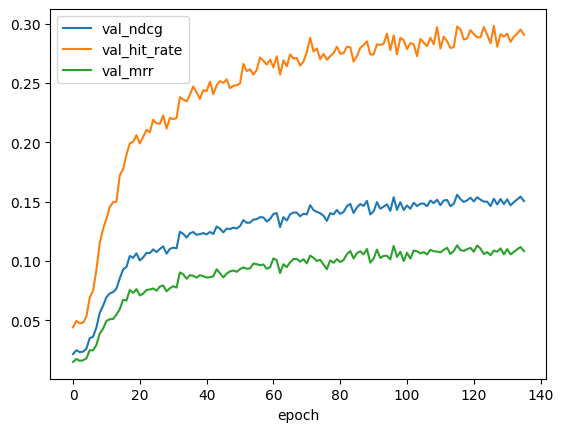

In [10]:
history = extract_validation_history(trainer.logger.experiment.log_dir)
history.drop(columns=['step', 'time']).plot(x="epoch")

## Predict validation

In [11]:
val_users = validation.user_id.unique()
test_users = test.user_id.unique()

train_for_val = train[train.user_id.isin(val_users)]
train_for_test = train[train.user_id.isin(test_users)]

predict_for_val_dataset = MaskedLMPredictionDataset(train_for_val, max_length=MAX_LENGTH)
predict_for_val_loader = DataLoader(
    predict_for_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

predict_for_test_dataset = MaskedLMPredictionDataset(train_for_test, max_length=MAX_LENGTH)
predict_for_test_loader = DataLoader(
    predict_for_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

In [12]:
val_preds = trainer.predict(model=seqrec_module, dataloaders=predict_for_val_loader)
val_recs = preds2recs(val_preds)
print(val_recs.shape)
val_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 12/12 [00:05<00:00, -14.41it/s]
(30200, 3)


,user_id,item_id,prediction
0,2,317,9.546230
1,2,330,9.284662
2,2,1877,8.851225
3,2,2394,8.599367
4,2,293,8.528594


In [13]:
%%time
evaluator = Evaluator(col_time_idx='time_idx')
val_metrics = pd.Series(evaluator.compute_metrics(validation, val_recs, train))
val_metrics

CPU times: user 1.78 s, sys: 453 ms, total: 2.23 s
Wall time: 2.23 s


map@10          0.081003
ndcg@10         0.166425
recall@10       0.154901
coverage@10     0.558108
entropy@10     10.083784
novelty@10     10.505365
dtype: float64

In [14]:
evaluator.compute_metrics_by_time_idx(validation, val_recs)

,map@10,ndcg@10,recall@10
0,0.111334,0.153054,0.291060
1,0.087104,0.125326,0.252318
2,0.071914,0.102827,0.205960
3,0.053322,0.079928,0.168543
4,0.045848,0.069626,0.149338
5,0.042596,0.063541,0.133444
6,0.032839,0.050101,0.107947
7,0.026398,0.040164,0.086755
8,0.026246,0.038940,0.081788
9,0.021020,0.032656,0.071854


In [16]:
evaluator.compute_metrics_by_time_idx(validation, val_recs, top_k_gt=True)

,map@10,ndcg@10,recall@10
0,0.111334,0.153054,0.291060
1,0.110101,0.170688,0.271689
2,0.108844,0.178892,0.249779
3,0.103548,0.180018,0.229470
4,0.099608,0.180013,0.213444
5,0.096648,0.179837,0.200110
6,0.092854,0.177131,0.186944
7,0.088367,0.173156,0.174421
8,0.084721,0.170057,0.164128
9,0.081003,0.166425,0.154901


## Predict test

In [17]:
preds_test = trainer.predict(model=seqrec_module, dataloaders=predict_for_test_loader)

test_recs = preds2recs(preds_test)
print(test_recs.shape)
test_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 12/12 [00:05<00:00, -14.95it/s]
(30200, 3)


,user_id,item_id,prediction
0,1,2,6.087904
1,1,35,6.079896
2,1,319,5.119205
3,1,2397,5.108581
4,1,594,5.025852


In [18]:
%%time
test_metrics = pd.Series(evaluator.compute_metrics(test, test_recs, train))
test_metrics

CPU times: user 1.85 s, sys: 693 ms, total: 2.55 s
Wall time: 2.55 s


map@10          0.081182
ndcg@10         0.166826
recall@10       0.154636
coverage@10     0.556486
entropy@10     10.116105
novelty@10     10.549081
dtype: float64

In [19]:
evaluator.compute_metrics_by_time_idx(test, test_recs, )

,map@10,ndcg@10,recall@10
0,0.116945,0.161039,0.306291
1,0.088367,0.125609,0.248675
2,0.072869,0.103087,0.203974
3,0.056633,0.084906,0.179139
4,0.047497,0.070313,0.146689
5,0.041027,0.061830,0.132119
6,0.033697,0.051597,0.111589
7,0.022937,0.035975,0.079470
8,0.022856,0.035104,0.076490
9,0.018743,0.028522,0.061921


In [20]:
evaluator.compute_metrics_by_time_idx(test, test_recs, top_k_gt=True) 

,map@10,ndcg@10,recall@10
0,0.116945,0.161039,0.306291
1,0.114535,0.175757,0.277483
2,0.112166,0.182894,0.252980
3,0.107775,0.185291,0.234520
4,0.103692,0.184827,0.216954
5,0.099674,0.183614,0.202815
6,0.095203,0.180973,0.189782
7,0.090059,0.175632,0.175993
8,0.085624,0.171456,0.164937
9,0.081182,0.166826,0.154636
